# Simulation and Inference of Interferometry on Growing Thin Films

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

## Imports

In [57]:
# numerics
import jax.numpy as jnp
import jax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# our library
from reflax import polanalyze, variable_layer_thickness_simulation

## Simulation

### General Setup

Let us first specify parameters of the experimental setup

In [58]:
wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)
polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [59]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

backside_mode = 1

and consider a setup with two static-thickness layers with parameters

In [60]:
static_layer_thicknesses = jnp.array([24.2, 10.0])
permeability_static_size_layers = jnp.array([1.0, 1.0])
permittivity_static_size_layers = jnp.array([1.57**2, 1.45704**2])

Let there further be a layer of variable thickness, with properties

In [61]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

### Growth model for the variable layer

We simulate over the timespan

In [62]:
final_time = 7049
time_points = jnp.arange(0, final_time)

Given a linear growth rate

In [63]:
layer_growing_rate = 747.9 / (7049 / 60) / 60

this yields the following thicknesses of the variable layer

In [64]:
variable_layer_thicknesses = time_points * layer_growing_rate

### Running the simulation

In [65]:
reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = variable_layer_thicknesses
)

### Profiling the simulation

In [66]:
%%timeit
reflection_coefficients, transmission_coefficients, conservation_checks = jax.block_until_ready(variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = variable_layer_thicknesses
))

12.3 ms ± 898 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Plotting the result

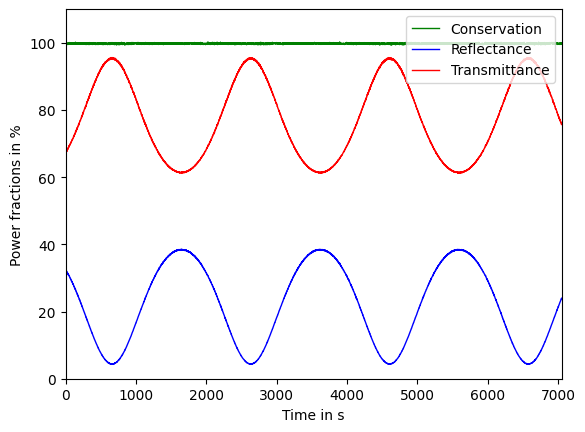

In [67]:
plt.plot(time_points, conservation_checks * 100, '-g', linewidth=1, label="Conservation")
plt.plot(time_points, reflection_coefficients * 100, '-b', linewidth=1, label="Reflectance")
plt.plot(time_points, transmission_coefficients * 100, '-r', linewidth=1, label="Transmittance")
plt.xlim([0, final_time])
plt.ylim([0, 110])
plt.xlabel("Time in s")
plt.ylabel("Power fractions in %")
plt.legend(loc="upper right")

## Data Analysis

Text(0.5, 1.0, 'measurement')

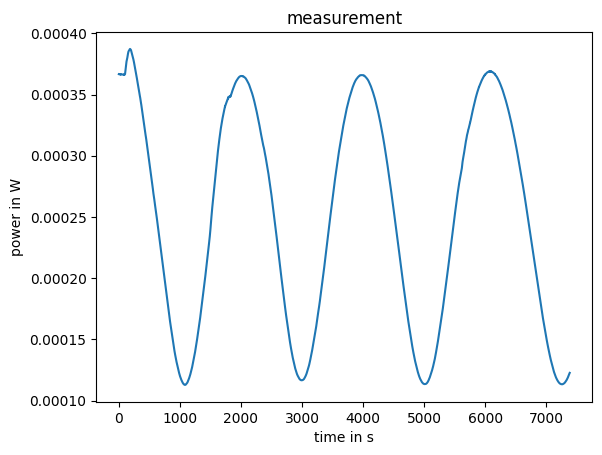

In [68]:
# Define the CSV file path
file_path = 'data/measurement.csv'

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = jnp.asarray(df['Time Since Start (seconds)'])
power_measured = jnp.asarray(df["Power (W)"])

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("measurement")


There seem to be artefacts in the measurement at the beginning up until ~1800 seconds (see the non-smooth transition there). We will cut this part of the measurement away.

In [69]:
time_points_measured = time_points_measured[1850:]
power_measured = power_measured[1850:]

Which looks much better

Text(0.5, 1.0, 'measurement')

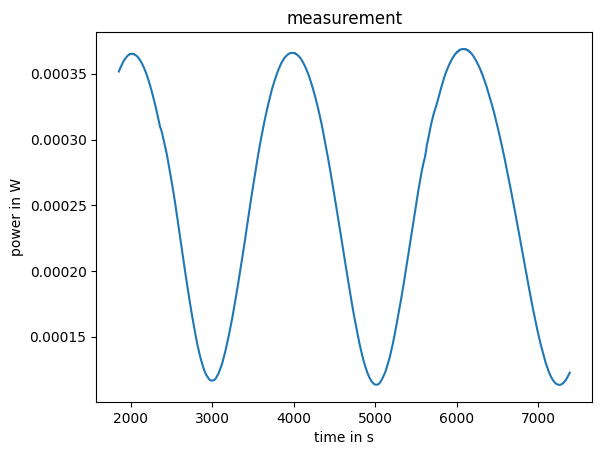

In [ ]:
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")

## Inference by hand

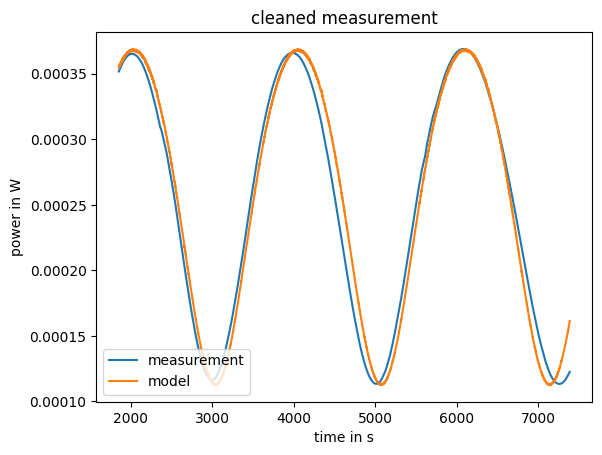

In [ ]:
initial_layer_thickness = 170
layer_growing_acceleration = -0.0000004

# simple accelerated model
layer_thickness_model = initial_layer_thickness + layer_growing_rate * time_points_measured + layer_growing_acceleration * time_points_measured ** 2

reflection_coefficients, _, _ = variable_layer_thickness_simulation(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component,
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    backside_mode = backside_mode,
    permeability_static_size_layers = permeability_static_size_layers,
    permittivity_static_size_layers = permittivity_static_size_layers,
    static_layer_thicknesses = static_layer_thicknesses,
    permeability_variable_layer = permeability_variable_layer,
    permittivity_variable_layer = permittivity_variable_layer,
    variable_layer_thicknesses = layer_thickness_model
)

a = 0.00075
b = 0.00008
power_model = a * reflection_coefficients + b

plt.plot(time_points_measured, power_measured, label = "measurement")
plt.plot(time_points_measured, power_model, label = "model")
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")
plt.legend(loc = "lower left")